In [1]:
# Install necessary libraries (if not already installed)
!pip install torch torchvision matplotlib

# Import everything we need
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if we have a GPU. Use it if available for much faster training!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Let's define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Create our valuable "victim" model and send it to the GPU/CPU
victim_model = SimpleCNN().to(device)
print("Victim model created!")

100%|██████████| 170M/170M [00:02<00:00, 66.6MB/s]


Victim model created!


In [3]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(victim_model.parameters(), lr=0.001)

# Train the model
epochs = 10 # We'll train for 10 passes through the dataset
for epoch in range(epochs):
    victim_model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = victim_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader):.4f}")

print('Finished Training Victim Model!')

# Let's check its accuracy to make sure it learned
correct = 0
total = 0
victim_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = victim_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the victim model on the 10000 test images: {100 * correct / total:.2f}%')

Epoch 1/10 - Loss: 1.3757
Epoch 2/10 - Loss: 1.0123
Epoch 3/10 - Loss: 0.8643
Epoch 4/10 - Loss: 0.7643
Epoch 5/10 - Loss: 0.6746
Epoch 6/10 - Loss: 0.5961
Epoch 7/10 - Loss: 0.5292
Epoch 8/10 - Loss: 0.4710
Epoch 9/10 - Loss: 0.4237
Epoch 10/10 - Loss: 0.3756
Finished Training Victim Model!
Accuracy of the victim model on the 10000 test images: 74.38%


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.5MB/s]


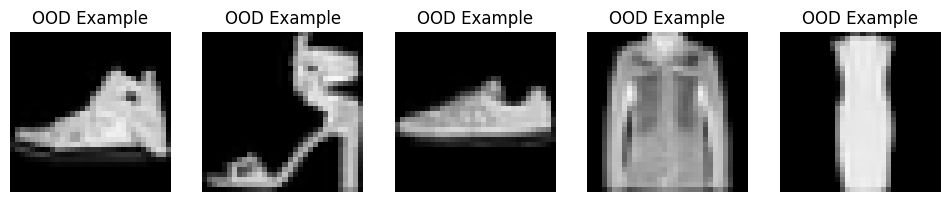

In [4]:
# We will use Fashion-MNIST as our "weird" OOD data
# We need to transform it to look like CIFAR-10 images (32x32, 3 channels)
ood_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert to 3-channel
    transforms.Resize(32), # Resize to CIFAR-10's 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

ood_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=ood_transform)
ood_loader = torch.utils.data.DataLoader(ood_trainset, batch_size=64, shuffle=True)

# Let's visualize some "weird" data to confirm
dataiter = iter(ood_loader)
images, _ = next(dataiter)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    ax = axes[i]
    img = images[i] / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f'OOD Example')
plt.show()

In [6]:
# Let's test our function quickly
sample_image, _ = next(iter(testloader))
sample_image = sample_image[0:1].to(device) # Get one test image

print("Testing on a GOOD (CIFAR-10) image:")
good_pred = defensive_predict(victim_model, sample_image)
# FIXED THE NEXT TWO LINES: Added .detach()
print(f"Original prediction logits: {victim_model(sample_image).cpu().detach().numpy()}")
print(f"Defensive prediction logits: {good_pred.cpu().detach().numpy()}\n")

# Test on a WEIRD image
sample_ood_image, _ = next(iter(ood_loader))
sample_ood_image = sample_ood_image[0:1].to(device)

print("Testing on a WEIRD (Fashion-MNIST) image:")
weird_pred = defensive_predict(victim_model, sample_ood_image)
# FIXED THE NEXT TWO LINES: Added .detach()
print(f"Original prediction logits: {victim_model(sample_ood_image).cpu().detach().numpy()}")
print(f"Defensive prediction logits: {weird_pred.cpu().detach().numpy()}")

Testing on a GOOD (CIFAR-10) image:
Debug: Added LARGE noise (This is probably an attacker!)
Original prediction logits: [[-4.4070663 -4.5388727 -4.0882287  5.6999173 -5.6370173  5.3106775
  -1.2564044 -5.775781  -4.9706807 -7.081596 ]]
Defensive prediction logits: [[ -5.9440527  -6.174349   -4.8525634   6.1462426  -2.7078621   7.1146717
   -3.9767573  -4.6921525  -4.0360703 -10.706835 ]]

Testing on a WEIRD (Fashion-MNIST) image:
Debug: Added LARGE noise (This is probably an attacker!)
Original prediction logits: [[-3.8789806  -3.4692135   0.45689565  1.3539371  -5.16403    -2.768935
  -3.022712   -0.29190814 -2.6287363  -8.356752  ]]
Defensive prediction logits: [[ -5.736379    -4.9879284    0.24171509   4.0394473   -5.3002005
   -2.6360903   -2.6029272    2.158502    -4.402639   -12.267609  ]]


In [7]:
# Simulate the attacker collecting queries and answers (without defense)
# We'll use our OOD data (Fashion-MNIST) to query the model
X_train_theft = []
y_train_theft = []

victim_model.eval()
with torch.no_grad():
    for images, _ in ood_loader:
        images = images.to(device)
        # Query the original, undefended model
        predictions = victim_model(images)
        # Store the query and the model's answer
        X_train_theft.append(images.cpu())
        y_train_theft.append(predictions.cpu())

# Combine the stolen dataset
X_theft = torch.cat(X_train_theft)
y_theft = torch.cat(y_train_theft)

# Create a new model for the thief
thief_model = SimpleCNN().to(device)
thief_criterion = nn.MSELoss() # We use MSE loss to mimic the model's outputs
thief_optimizer = optim.Adam(thief_model.parameters(), lr=0.001)

# Train the thief model on the stolen data
thief_model.train()
for epoch in range(5): # Short training for the thief
    running_loss = 0.0
    for i in range(0, len(X_theft), 64): # Simple batch loop
        batch_X = X_theft[i:i+64].to(device)
        batch_y = y_theft[i:i+64].to(device)

        thief_optimizer.zero_grad()
        thief_outputs = thief_model(batch_X)
        loss = thief_criterion(thief_outputs, batch_y)
        loss.backward()
        thief_optimizer.step()
        running_loss += loss.item()
    print(f"Thief Epoch {epoch+1} - Loss: {running_loss/(i/64):.4f}")

# Evaluate the thief model on the CIFAR-10 test set
correct_theft = 0
total = 0
thief_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = thief_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_theft += (predicted == labels).sum().item()

print(f'Accuracy of the THIEF model (NO DEFENSE): {100 * correct_theft / total:.2f}%')

Thief Epoch 1 - Loss: 9.6710
Thief Epoch 2 - Loss: 5.6590
Thief Epoch 3 - Loss: 4.8871
Thief Epoch 4 - Loss: 4.5168
Thief Epoch 5 - Loss: 4.2721
Accuracy of the THIEF model (NO DEFENSE): 34.34%


In [8]:
# Simulate the attacker collecting queries and answers (WITH DEFENSE)
X_train_theft_defended = []
y_train_theft_defended = []

victim_model.eval()
with torch.no_grad():
    for images, _ in ood_loader:
        images = images.to(device)
        # Query the DEFENDED model this time!
        predictions = defensive_predict(victim_model, images)
        # Store the query and the model's USELESS answer
        X_train_theft_defended.append(images.cpu())
        y_train_theft_defended.append(predictions.cpu())

# Combine the stolen dataset
X_theft_def = torch.cat(X_train_theft_defended)
y_theft_def = torch.cat(y_train_theft_defended)

# Create another new model for the thief
thief_model_defended = SimpleCNN().to(device)
thief_optimizer_def = optim.Adam(thief_model_defended.parameters(), lr=0.001)

# Train the thief model on the USELESS stolen data
thief_model_defended.train()
for epoch in range(5):
    running_loss = 0.0
    for i in range(0, len(X_theft_def), 64):
        batch_X = X_theft_def[i:i+64].to(device)
        batch_y = y_theft_def[i:i+64].to(device)

        thief_optimizer_def.zero_grad()
        thief_outputs = thief_model_defended(batch_X)
        loss = thief_criterion(thief_outputs, batch_y)
        loss.backward()
        thief_optimizer_def.step()
        running_loss += loss.item()
    print(f"Thief (Defended) Epoch {epoch+1} - Loss: {running_loss/(i/64):.4f}")

# Evaluate the thief model trained on defended data
correct_theft_def = 0
total = 0
thief_model_defended.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = thief_model_defended(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_theft_def += (predicted == labels).sum().item()

print(f'Accuracy of the THIEF model (WITH DEFENSE): {100 * correct_theft_def / total:.2f}%')

Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added LARGE noise (This is probably an attacker!)
Debug: Added LARGE noise (This is probably an attacker!)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added LARGE noise (This is probably an attacker!)
Debug: Added LARGE noise (This is probably an attacker!)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added small noise (This is a legitimate user)
Debug: Added LARGE noise (This is probably an attacker!)
Debug: Added LARGE noise (This is probably an attacker!)
Debug: Added small noise (This is a legitimate user)
Debug: Added LARGE noi